<a href="https://colab.research.google.com/github/Hoyr/USGSAssesment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
try:
  import obspy
except:
  !pip install obspy
  import obspy

import sqlite3

#Assumes .mseed files are at root of colab instance
filenames = ["SEP01.mseed", "SEP02.mseed", "SEP03.mseed"]
mseed_files = []
for filename in filenames:
  mseed_files.append(obspy.read(filename))

db_connection = sqlite3.connect("SEP_database.db")
db_cursor = db_connection.cursor()

db_cursor.execute('DROP TABLE IF EXISTS networks')
db_cursor.execute('DROP TABLE IF EXISTS stations')
db_cursor.execute('DROP TABLE IF EXISTS channels')
db_cursor.execute('DROP TABLE IF EXISTS traces')

#This structure is overly complex for the one network, station and channel used
#in the mseed files
db_cursor.execute('''
  CREATE table networks (
    network_id INTEGER PRIMARY KEY,
    network_code TEXT NOT NULL UNIQUE
  )
''')

db_cursor.execute('''
  CREATE table stations (
    station_id INTEGER PRIMARY KEY,
    network_id INTEGER NOT NULL,
    station_code TEXT NOT NULL,
    UNIQUE (network_id, station_code),
    FOREIGN KEY (network_id) REFERENCES networks(network_id)
  )
''')

db_cursor.execute('''
  CREATE table channels (
    channel_id INTEGER PRIMARY KEY,
    channel_code TEXT NOT NULL UNIQUE
  )
''')

db_cursor.execute('''
  CREATE table traces (
    trace_id INTEGER PRIMARY KEY,
    station_id INTEGER NOT NULL,
    channel_id INTEGER NOT NULL,
    starttime DATETIME NOT NULL,
    endtime DATETIME NOT NULL,
    sampling_rate REAL NOT NULL,
    delta REAL NOT NULL,
    num_samples INTEGER NOT NULL,
    calibration REAL NOT NULL,
    trace_data BLOB NOT NULL,
    UNIQUE (station_id, channel_id, starttime, endtime),
    FOREIGN KEY (station_id) REFERENCES stations(station_id),
    FOREIGN KEY (channel_id) REFERENCES channels(channel_id)
  )
''')

network_codes = []
channel_codes = []
stations = []
trace_count = 0
for mseed_file in mseed_files:
  for trace in mseed_file:
    trace_count += 1
    if trace.stats.network not in network_codes:
      network_codes.append(trace.stats.network)
    if trace.stats.channel not in channel_codes:
      channel_codes.append(trace.stats.channel)
    if (trace.stats.network, trace.stats.station) not in stations:
      stations.append((trace.stats.network, trace.stats.station))

for network_code in network_codes:
  db_cursor.execute("INSERT INTO networks (network_code) VALUES (?)",
    (network_code,))

for channel_code in channel_codes:
  db_cursor.execute("INSERT INTO channels (channel_code) VALUES (?)",
    (channel_code,))

for station in stations:
  db_cursor.execute("SELECT network_id FROM networks WHERE network_code = ?",
    (station[0],))
  network_id = db_cursor.fetchone()[0]
  db_cursor.execute("INSERT INTO stations (network_id, station_code) VALUES (?, ?)",
    (network_id, station[1]))

for mseed_file in mseed_files:
  for trace in mseed_file:
    db_cursor.execute('''
      SELECT station_id
      FROM stations
      WHERE network_id = (
        SELECT network_id
        FROM networks
        WHERE network_code = ?
        )
        AND station_code = ?''',
      (trace.stats.network, trace.stats.station))
    station_id = db_cursor.fetchone()[0]
    db_cursor.execute("SELECT channel_id FROM channels WHERE channel_code = ?",
      (trace.stats.channel,))
    channel_id = db_cursor.fetchone()[0]
    db_cursor.execute('''
      INSERT INTO traces (station_id, channel_id, starttime, endtime,
        sampling_rate, delta, num_samples, calibration, trace_data)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)''',
      (station_id, channel_id, str(trace.stats.starttime),
       str(trace.stats.endtime), trace.stats.sampling_rate, trace.stats.delta,
       trace.stats.npts, trace.stats.calib, trace.data))
db_connection.commit()
db_connection.close()




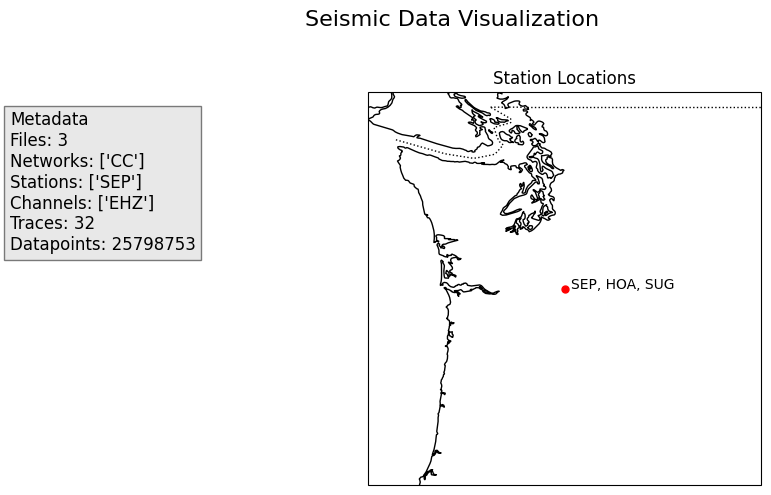

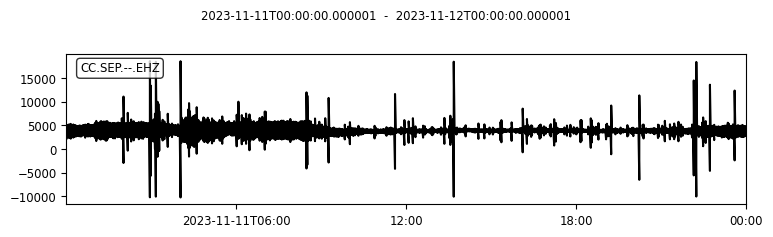

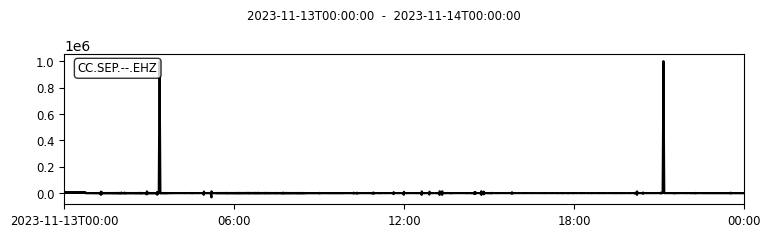

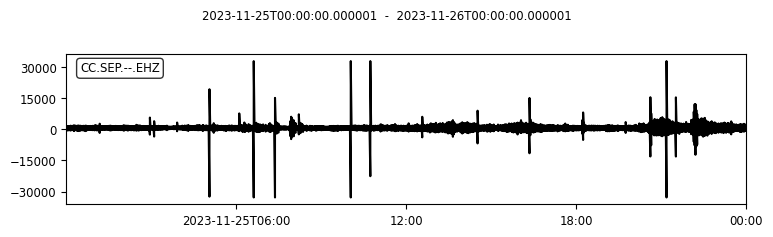

In [125]:
# prompt: Create a visualization including a title, metadata, Helicorder-style charts, and a map

import matplotlib.pyplot as plt
try:
  import obspy
except:
  !pip install obspy
  import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
try:
  import cartopy.crs as ccrs
  import cartopy.feature as cfeature
except:
  !pip install cartopy
  import cartopy.crs as ccrs
  import cartopy.feature as cfeature
import numpy as np

# Assuming mseed_files and database connection details are available from the previous code

# 1. Fetch station metadata from IRIS
client = Client("IRIS")
try:
    iris_inv = client.get_stations(network="*", station="HOA,SUG", level="station")
except Exception as e:
    print(f"Error fetching station data from IRIS: {e}")
    iris_inv = None #In case of an error, inv will be None

# 2. Prepare map data
station_codes = []
network_codes = []
for mseed_file in mseed_files:
    for trace in mseed_file:
      if trace.stats.station not in station_codes:
        station_codes.append(trace.stats.station)
      if trace.stats.network not in network_codes:
        network_codes.append(trace.stats.network)

stations = ','.join(station_codes)
networks = ','.join(network_codes)
try:
    inv = client.get_stations(network=networks, station=stations, level="station")
except Exception as e:
    print(f"Error fetching station data from IRIS: {e}")
    inv = None #In case of an error, inv will be None


if inv is not None and iris_inv is not None:
    inv.extend(iris_inv)
elif inv is None and iris_inv is not None:
    inv = iris_inv

stations_data = []
for network in inv:
  for station in network:
      stations_data.append({
          'network': network.code,
          'station': station.code,
          'latitude': station.latitude,
          'longitude': station.longitude
      })

#Fuse stations that are to close together
i = 0
while i < len(stations_data):
    j = i + 1
    while j < len(stations_data):
        if ((stations_data[i]['longitude'] - stations_data[j]['longitude'])**2
            - (stations_data[i]['latitude'] - stations_data[j]['latitude'])**2) < 0.6**2:
            if stations_data[j]['network'] not in stations_data[i]['network']:
                stations_data[i]['network'] = stations_data[i]['network'] + ', ' + stations_data[j]['network']
            if stations_data[j]['station'] not in stations_data[i]['station']:
                stations_data[i]['station'] = stations_data[i]['station'] + ', ' + stations_data[j]['station']
            stations_data[i]['longitude'] = (stations_data[i]['longitude'] + stations_data[j]['longitude']) / 2
            stations_data[i]['latitude'] = (stations_data[i]['latitude'] + stations_data[j]['latitude']) / 2
            stations_data.pop(j)
            j -= 1
        j += 1
    i += 1


file_metadata = {
    'Files': 0,
    'Networks': [],
    'Stations': [],
    'Channels': [],
    'Traces': 0,
    'Datapoints': 0
}
for mseed_file in mseed_files:
    file_metadata['Files'] += 1
    for trace in mseed_file:
        if trace.stats.network not in file_metadata['Networks']:
            file_metadata['Networks'].append(trace.stats.network)
        if trace.stats.station not in file_metadata['Stations']:
            file_metadata['Stations'].append(trace.stats.station)
        if trace.stats.channel not in file_metadata['Channels']:
            file_metadata['Channels'].append(trace.stats.channel)
        file_metadata['Traces'] += 1
        file_metadata['Datapoints'] += trace.stats.npts

plt.figure(figsize=(9.2, 5))

# Title
plt.suptitle("Seismic Data Visualization", fontsize=16)

# Metadata Section
metadata_texts = ["Metadata"]
for key, value in file_metadata.items():
    metadata_texts.append(f"{key}: {value}")
metadata_text='\n'.join(metadata_texts)
plt.figtext(0.02, 0.5, metadata_text, fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Map
plt.subplot(1, 4, (2, 4), projection=ccrs.PlateCarree())
plt.title("Station Locations")
ax = plt.gca()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

for station in stations_data:
    plt.plot(station['longitude'], station['latitude'], marker='o', color='red', markersize=5, transform=ccrs.Geodetic())
    plt.text(station['longitude'] + 0.1, station['latitude'], station['station'], transform=ccrs.Geodetic())

max_longitude = max(stations_data, key=lambda x: x['longitude'])['longitude']
max_latitude = max(stations_data, key=lambda x: x['latitude'])['latitude']
min_longitude = min(stations_data, key=lambda x: x['longitude'])['longitude']
min_latitude = min(stations_data, key=lambda x: x['latitude'])['latitude']

ax.set_extent([min_longitude - 3, max_longitude + 3, min_latitude - 3, max_latitude + 3])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#Spam the Helicorder plots
traces = []
for mseed_file in mseed_files:
    file_traces = {}
    for trace in mseed_file:
        trace_id=str(trace.stats.network) + ' ' + str(trace.stats.station) + ' ' + str(trace.stats.channel)
        if trace_id not in file_traces:
            file_traces[trace_id] = trace
        else:
            file_traces[trace_id] += trace
    traces.append(file_traces)

for i, file_traces in enumerate(traces):
    for trace_id, trace in file_traces.items():
        trace.plot()